<a href="https://colab.research.google.com/github/ronaldosilvak/estag_experience_itau/blob/main/EstagExperience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, text

# **Upando as planilhas**

In [92]:
clientes = pd.read_excel('/content/Planilha Case - Estag Experience Dados.xlsx', sheet_name='Cliente', header=1)
emprestimos = pd.read_excel('/content/Planilha Case - Estag Experience Dados.xlsx', sheet_name='Empréstimos', header=1)
residencia = pd.read_excel('/content/Planilha Case - Estag Experience Dados.xlsx', sheet_name='Residência', header=1)
emprego = pd.read_excel('/content/Planilha Case - Estag Experience Dados.xlsx', sheet_name='Emprego', header=1)
statuspag = pd.read_excel('/content/Planilha Case - Estag Experience Dados.xlsx', sheet_name='Status pagamento', header=1)

# **Retirando espaços dos cabeçalhos**

In [93]:
clientes.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)
emprestimos.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)
residencia.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)
emprego.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)
statuspag.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)

# **Utilizando SQL Alchemy**

In [94]:
engine = create_engine('sqlite:///:memory:')

In [95]:
clientes.to_sql('clientes', engine, index=False)
emprestimos.to_sql('emprestimos', engine, index=False)
residencia.to_sql('residencia', engine, index=False)
emprego.to_sql('emprego', engine, index=False)
statuspag.to_sql('statuspag', engine, index=False)

5

# **Criando uma função para retornar as querys realizadas**

In [96]:
def sql_to_df(query):
  with engine.connect() as conexao:
    consulta = conexao.execute(text(query))
    dados = consulta.fetchall()
  return pd.DataFrame(dados, columns=consulta.keys())

# **Testando as querys em todas as planilhas**

In [97]:
query_clientes = '''SELECT *
FROM clientes'''

In [98]:
query_emprestimos = '''SELECT *
FROM emprestimos'''

In [99]:
query_residencia = '''SELECT *
FROM residencia'''

In [100]:
query_emprego = '''SELECT *
FROM emprego'''

In [101]:
query_statuspag = '''SELECT *
FROM statuspag'''

In [102]:
sql_to_df(query_clientes).head(1)

,ID_Cliente,Nome,Idade,Renda_Mensal,Nome_da_Mãe,Residência_Permanente,Cidade,Estado,Tipo_de_Emprego
0,1,BRUNA APARECIDA,22,1500,Maria,NÃO,Sâo Paulo,SP,Estagiário


In [103]:
sql_to_df(query_emprestimos).head(1)

,ID_Empréstimo,ID_Cliente,Tipo_de_Empréstimo,Valor,Prazo,Status_Pagamento,Possui_Empréstimo?,Observações
0,101,1,Educacional,10000,24,Pago,Sim,Não possui cartão de crédito


In [104]:
sql_to_df(query_residencia).head(1)

,ID_Residência,ID_Cliente,Tipo_de_Residência,Endereço
0,401,1,Alugada,"Rua dos Trilhos, 457"


In [105]:
sql_to_df(query_emprego).head(1)

,ID_Emprego,ID_Cliente,Tipo_de_Emprego
0,301,1,Estagiário


In [106]:
sql_to_df(query_statuspag).head(1)

,ID_Status_Pagamento,ID_Empréstimo,Data_de_Pagamento,Valor_Pago,Status
0,201,101,2024-03-15 00:00:00.000000,416.7,Pago


# **Realizando Joins**

## Diagrama

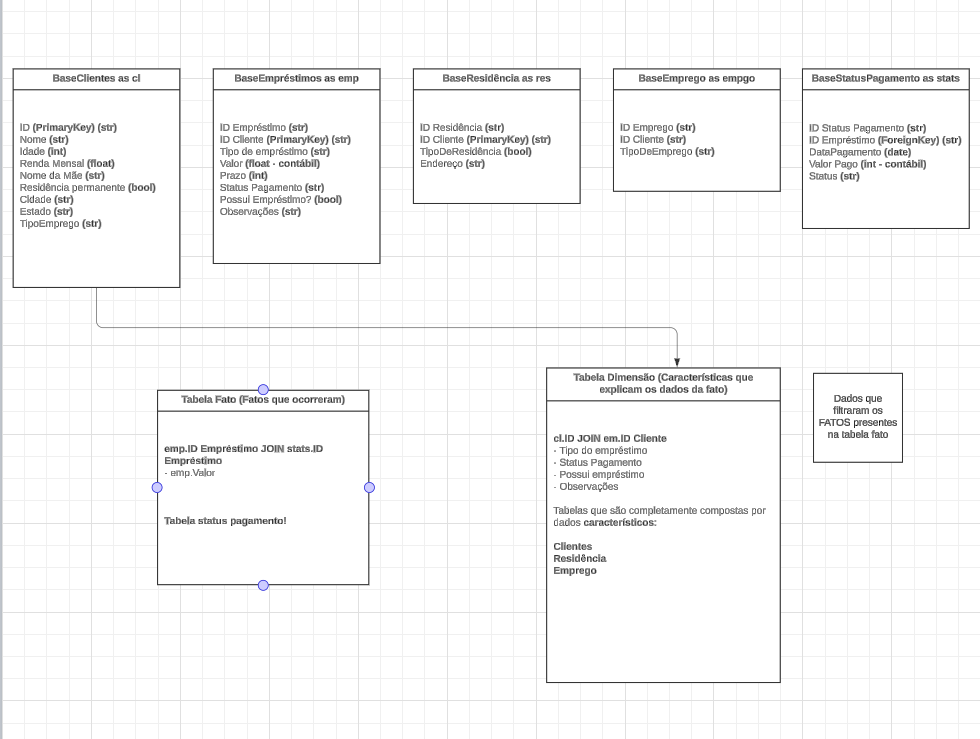

## Criando tabela fato

In [107]:
tabela_fato = '''SELECT *
FROM statuspag sp
'''

In [108]:
tabela_fato = '''SELECT
  sp.Status Pagamento,
  sp.ID_Empréstimo,
  sp.Data_de_Pagamento,
  sp.Valor_Pago,
  sp.Status,
  emp.Valor,
  emp.ID_Cliente,
  emp.Prazo,
  emp.Tipo_de_Empréstimo

FROM statuspag sp
JOIN emprestimos emp
ON sp.ID_Empréstimo=emp.ID_Empréstimo
'''

In [109]:
df_tabela_fato = sql_to_df(tabela_fato)
df_tabela_fato.rename(columns={'Valor':'Valor_Empréstimo'}, inplace=True)
df_tabela_fato

,Pagamento,ID_Empréstimo,Data_de_Pagamento,Valor_Pago,Status,Valor_Empréstimo,ID_Cliente,Prazo,Tipo_de_Empréstimo
0,Pago,101,2024-03-15 00:00:00.000000,416.7,Pago,10000,1,24,Educacional
1,Pendente,102,2024-04-05 00:00:00.000000,1388.8,Pendente,50000,2,36,Habitacional
2,Pago,103,2024-03-26 00:00:00.000000,416.7,Pago,20000,3,48,Automóvel
3,Pendente,104,2024-03-31 00:00:00.000000,583.3,Pendente,7000,4,12,Pessoal
4,Pendente,105,2024-04-10 00:00:00.000000,125.0,Pendente,3000,5,24,Pessoal


## Criando tabela dimensão/característica

In [110]:
sql_to_df('''SELECT * FROM residencia''')

,ID_Residência,ID_Cliente,Tipo_de_Residência,Endereço
0,401,1,Alugada,"Rua dos Trilhos, 457"
1,402,2,Própria,"Rua Domingos de Santa Maria, 456"
2,403,3,Própria,"Rua Manoel Fernandes Leão, 789"
3,404,4,Alugada,"Rua Pretoria, 124"
4,405,5,Própria,"Av. Paulista, 123"


In [111]:
sql_to_df('''SELECT * FROM emprego''')

,ID_Emprego,ID_Cliente,Tipo_de_Emprego
0,301,1,Estagiário
1,302,2,CLT
2,303,3,Autônomo
3,304,4,CLT
4,305,5,CLT


In [112]:
"""
    SELECT *
    FROM clientes
    INNER JOIN outra_tabela ON clientes.coluna_comum = outra_tabela.coluna_comum
"""

'\n    SELECT *\n    FROM clientes\n    INNER JOIN outra_tabela ON clientes.coluna_comum = outra_tabela.coluna_comum\n'

In [113]:
query_tabela_dimensao = '''SELECT *
FROM residencia rd
INNER JOIN clientes ON rd.ID_Cliente = clientes.ID_Cliente;'''

In [114]:
tabela_dimensao = sql_to_df(query_tabela_dimensao)

In [115]:
tabela_dimensao

,ID_Residência,ID_Cliente,Tipo_de_Residência,Endereço,ID_Cliente,Nome,Idade,Renda_Mensal,Nome_da_Mãe,Residência_Permanente,Cidade,Estado,Tipo_de_Emprego
0,401,1,Alugada,"Rua dos Trilhos, 457",1,BRUNA APARECIDA,22,1500,Maria,NÃO,Sâo Paulo,SP,Estagiário
1,402,2,Própria,"Rua Domingos de Santa Maria, 456",2,ANA,27,5000,Roseli,SIM,São Paulo,SP,CLT
2,403,3,Própria,"Rua Manoel Fernandes Leão, 789",3,LUCAS,30,10000,Marta,SIM,São Paulo,SP,Autônomo
3,404,4,Alugada,"Rua Pretoria, 124",4,FELIPE,29,0,Carla,NÃO,São Paulo,SP,Desempregado
4,405,5,Própria,"Av. Paulista, 123",5,MARIANA,25,5000,Leticia,SIM,São Paulo,SP,CLT


In [116]:
# removendo a coluna ID_Cliente que duplicou a mescla
tabela_dimensao = tabela_dimensao.loc[:, ~tabela_dimensao.columns.duplicated()]
tabela_dimensao


,ID_Residência,ID_Cliente,Tipo_de_Residência,Endereço,Nome,Idade,Renda_Mensal,Nome_da_Mãe,Residência_Permanente,Cidade,Estado,Tipo_de_Emprego
0,401,1,Alugada,"Rua dos Trilhos, 457",BRUNA APARECIDA,22,1500,Maria,NÃO,Sâo Paulo,SP,Estagiário
1,402,2,Própria,"Rua Domingos de Santa Maria, 456",ANA,27,5000,Roseli,SIM,São Paulo,SP,CLT
2,403,3,Própria,"Rua Manoel Fernandes Leão, 789",LUCAS,30,10000,Marta,SIM,São Paulo,SP,Autônomo
3,404,4,Alugada,"Rua Pretoria, 124",FELIPE,29,0,Carla,NÃO,São Paulo,SP,Desempregado
4,405,5,Própria,"Av. Paulista, 123",MARIANA,25,5000,Leticia,SIM,São Paulo,SP,CLT


# **Mesclando a última tabela utilizando pandas**

In [117]:
tabela_dimensao

,ID_Residência,ID_Cliente,Tipo_de_Residência,Endereço,Nome,Idade,Renda_Mensal,Nome_da_Mãe,Residência_Permanente,Cidade,Estado,Tipo_de_Emprego
0,401,1,Alugada,"Rua dos Trilhos, 457",BRUNA APARECIDA,22,1500,Maria,NÃO,Sâo Paulo,SP,Estagiário
1,402,2,Própria,"Rua Domingos de Santa Maria, 456",ANA,27,5000,Roseli,SIM,São Paulo,SP,CLT
2,403,3,Própria,"Rua Manoel Fernandes Leão, 789",LUCAS,30,10000,Marta,SIM,São Paulo,SP,Autônomo
3,404,4,Alugada,"Rua Pretoria, 124",FELIPE,29,0,Carla,NÃO,São Paulo,SP,Desempregado
4,405,5,Própria,"Av. Paulista, 123",MARIANA,25,5000,Leticia,SIM,São Paulo,SP,CLT


In [118]:
emprego

,ID_Emprego,ID_Cliente,Tipo_de_Emprego
0,301,1,Estagiário
1,302,2,CLT
2,303,3,Autônomo
3,304,4,CLT
4,305,5,CLT


In [119]:
tabela_dimensao = pd.merge(tabela_dimensao, emprego, on='ID_Cliente', how='left')
tabela_dimensao.drop(columns='Tipo_de_Emprego_x', axis=1, inplace=True)
df_tabela_dimensao = tabela_dimensao.rename(columns={'Tipo_de_Emprego_y':'Tipo_de_Emprego'})


# **Realizando cálculos**

In [120]:
df_tabela_dimensao

,ID_Residência,ID_Cliente,Tipo_de_Residência,Endereço,Nome,Idade,Renda_Mensal,Nome_da_Mãe,Residência_Permanente,Cidade,Estado,ID_Emprego,Tipo_de_Emprego
0,401,1,Alugada,"Rua dos Trilhos, 457",BRUNA APARECIDA,22,1500,Maria,NÃO,Sâo Paulo,SP,301,Estagiário
1,402,2,Própria,"Rua Domingos de Santa Maria, 456",ANA,27,5000,Roseli,SIM,São Paulo,SP,302,CLT
2,403,3,Própria,"Rua Manoel Fernandes Leão, 789",LUCAS,30,10000,Marta,SIM,São Paulo,SP,303,Autônomo
3,404,4,Alugada,"Rua Pretoria, 124",FELIPE,29,0,Carla,NÃO,São Paulo,SP,304,CLT
4,405,5,Própria,"Av. Paulista, 123",MARIANA,25,5000,Leticia,SIM,São Paulo,SP,305,CLT


In [121]:
df_tabela_fato

,Pagamento,ID_Empréstimo,Data_de_Pagamento,Valor_Pago,Status,Valor_Empréstimo,ID_Cliente,Prazo,Tipo_de_Empréstimo
0,Pago,101,2024-03-15 00:00:00.000000,416.7,Pago,10000,1,24,Educacional
1,Pendente,102,2024-04-05 00:00:00.000000,1388.8,Pendente,50000,2,36,Habitacional
2,Pago,103,2024-03-26 00:00:00.000000,416.7,Pago,20000,3,48,Automóvel
3,Pendente,104,2024-03-31 00:00:00.000000,583.3,Pendente,7000,4,12,Pessoal
4,Pendente,105,2024-04-10 00:00:00.000000,125.0,Pendente,3000,5,24,Pessoal


In [122]:
df_tabela_fato.rename(columns={'Prazo':'Prazo (em meses)'}, inplace=True)

# **EDA (Exploratory Data Analysis)**

In [123]:
df_tabela_fato

,Pagamento,ID_Empréstimo,Data_de_Pagamento,Valor_Pago,Status,Valor_Empréstimo,ID_Cliente,Prazo (em meses),Tipo_de_Empréstimo
0,Pago,101,2024-03-15 00:00:00.000000,416.7,Pago,10000,1,24,Educacional
1,Pendente,102,2024-04-05 00:00:00.000000,1388.8,Pendente,50000,2,36,Habitacional
2,Pago,103,2024-03-26 00:00:00.000000,416.7,Pago,20000,3,48,Automóvel
3,Pendente,104,2024-03-31 00:00:00.000000,583.3,Pendente,7000,4,12,Pessoal
4,Pendente,105,2024-04-10 00:00:00.000000,125.0,Pendente,3000,5,24,Pessoal


In [124]:
df_tabela_fato.rename(columns={'Valor_Pago':'Valor_Parcela'}, inplace=True)

In [125]:
df_tabela_dimensao

,ID_Residência,ID_Cliente,Tipo_de_Residência,Endereço,Nome,Idade,Renda_Mensal,Nome_da_Mãe,Residência_Permanente,Cidade,Estado,ID_Emprego,Tipo_de_Emprego
0,401,1,Alugada,"Rua dos Trilhos, 457",BRUNA APARECIDA,22,1500,Maria,NÃO,Sâo Paulo,SP,301,Estagiário
1,402,2,Própria,"Rua Domingos de Santa Maria, 456",ANA,27,5000,Roseli,SIM,São Paulo,SP,302,CLT
2,403,3,Própria,"Rua Manoel Fernandes Leão, 789",LUCAS,30,10000,Marta,SIM,São Paulo,SP,303,Autônomo
3,404,4,Alugada,"Rua Pretoria, 124",FELIPE,29,0,Carla,NÃO,São Paulo,SP,304,CLT
4,405,5,Própria,"Av. Paulista, 123",MARIANA,25,5000,Leticia,SIM,São Paulo,SP,305,CLT


<BarContainer object of 5 artists>

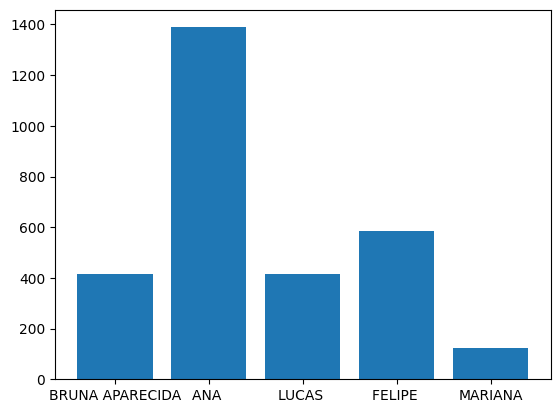

In [126]:
plt.bar(df_tabela_dimensao['Nome'], df_tabela_fato['Valor_Parcela'])

# **Preparando as bases para a construção da árvore**

A única mudança que as bases "Tree" possuem é a adição da coluna "risco", para ser a variável independente (y), onde as variáveis explicativas vão buscar entendê-las e buscar padrões para realizar predições em futuros clientes

In [127]:
# realizando a junção das tabelas fato e dimensão para, posteriormente, separá-las em variáveis de treino e teste
base_info_clientes = pd.merge(df_tabela_dimensao, df_tabela_fato, on='ID_Cliente', how='inner')

In [128]:
base_info_clientes.columns

Index(['ID_Residência', 'ID_Cliente', 'Tipo_de_Residência', 'Endereço', 'Nome',
       'Idade', 'Renda_Mensal', 'Nome_da_Mãe', 'Residência_Permanente',
       'Cidade', 'Estado', 'ID_Emprego', 'Tipo_de_Emprego', 'Pagamento',
       'ID_Empréstimo', 'Data_de_Pagamento', 'Valor_Parcela', 'Status',
       'Valor_Empréstimo', 'Prazo (em meses)', 'Tipo_de_Empréstimo'],
      dtype='object')

# **Separando variáveis de treino e teste**

Objetivo

Criar um modelo de Machine Learning que prediz a variável independente (y) "Risco".

In [129]:
base_info_clientes['Tipo_de_Empréstimo']

0     Educacional
1    Habitacional
2       Automóvel
3         Pessoal
4         Pessoal
Name: Tipo_de_Empréstimo, dtype: object

In [130]:
X = base_info_clientes.drop(['Nome_da_Mãe', 'Tipo_de_Residência', 'Endereço', 'Nome',
                             'ID_Residência', 'ID_Cliente', 'ID_Emprego',
                             'Data_de_Pagamento', 'Status', 'Pagamento', 'Tipo_de_Empréstimo'],axis=1).values
y = base_info_clientes[['Tipo_de_Empréstimo']].values

In [131]:
y

array([['Educacional'],
       ['Habitacional'],
       ['Automóvel'],
       ['Pessoal'],
       ['Pessoal']], dtype=object)

# **Realizando o pré-processamento dos dados (Label Encoder)**

In [132]:
from sklearn.preprocessing import LabelEncoder

In [133]:
le_residencia = LabelEncoder()
le_cidade = LabelEncoder()
le_estado = LabelEncoder()
le_tipo_emprego = LabelEncoder()

In [134]:
X[:, 2] = le_residencia.fit_transform(X[:, 2])
X[:, 3] = le_cidade.fit_transform(X[:, 3])
X[:, 4] = le_estado.fit_transform(X[:, 4])
X[:, 5] = le_tipo_emprego.fit_transform(X[:, 5])

In [135]:
X

array([[22, 1500, 0, 0, 0, 2, 101, 416.7, 10000, 24],
       [27, 5000, 1, 1, 0, 1, 102, 1388.8, 50000, 36],
       [30, 10000, 1, 1, 0, 0, 103, 416.7, 20000, 48],
       [29, 0, 0, 1, 0, 1, 104, 583.3, 7000, 12],
       [25, 5000, 1, 1, 0, 1, 105, 125.0, 3000, 24]], dtype=object)

In [136]:
le_pagamento = LabelEncoder()

y = le_pagamento.fit_transform(y)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [137]:
y

array([1, 2, 0, 3, 3])

In [138]:
y

array([1, 2, 0, 3, 3])

# **Decision Tree**

In [139]:
from sklearn.model_selection import train_test_split

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [141]:
X_train.shape, X_test.shape

((3, 10), (2, 10))

In [142]:
y_train.shape, y_test.shape

((3,), (2,))

In [143]:
from sklearn.tree import DecisionTreeClassifier

In [144]:
decision_tree = DecisionTreeClassifier(criterion='entropy')
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

Por conta da infíma quantidade de dados o modelo teve uma acurácia de 0%, ou seja, o modelo de machine learning não conseguiu acertar nenhuma previsão. Isto se deve por conta da pequena quantidade de dados para treina-lo, isso implica negativamente no aprendizado do modelo.

In [145]:
# 0 - Moderado | 1 - alto | 2 - baixo
previsoes = decision_tree.predict(X_test)
previsoes

array([3, 3])

In [146]:
y_test

array([0, 1])

# **KNN (K-Nearest Neighbors)**

In [147]:
from sklearn.neighbors import KNeighborsClassifier

In [148]:
from sklearn.preprocessing import StandardScaler
scaler_clientes = StandardScaler()
X = scaler_clientes.fit_transform(X)

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [150]:
knn_clientes = KNeighborsClassifier(n_neighbors=3, metric='minkowski', p = 2)

In [151]:
knn_clientes.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [152]:
previsoes = knn_clientes.predict(X_test)
previsoes

array([3, 3])

In [153]:
y_test

array([0, 1])

In [154]:
from sklearn.metrics import accuracy_score, classification_report
accuracy_score(y_test, previsoes) # padronização

0.0

# **Exportando as tabelas**

In [155]:
df_tabela_dimensao.to_csv('dCliente', index=False)
df_tabela_fato.to_csv('fPagamentos', index=False)

In [156]:
df_tabela_dimensao.to_excel('dClienteExceltest.xlsx', index=False)
df_tabela_fato.to_excel('fPagamentosExceltest.xlsx', index=False)
base_info_clientes.to_excel('base_machine_learning.xlsx', index=False)